In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle as pkl
from scipy import stats

import csv
import sys
import pandas as pd
import os

from SelectionHelper import MakeAvgBDTcut
from DavioPlotter import *
    
cutMode = 0
cutmodedir = 'SignalRegion'
lowEpatch = False
vtxCut = 5



DAT_POT1 = 1.631e+20
DAT_POT2 = 2.750e+20
DAT_POT3 = 2.291e+20
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3


def poisson_errors(k, CL = 0.6827):
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


Welcome to JupyROOT 6.16/00


In [2]:
tag='3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'

filetaglist = {1:['data','dirt','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0'],
               2:['data','dirt','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE'],
               3:['data','dirt','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0']}

df = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        if not lowEpatch and 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_fset12_run%i.parquet.gzip'%(cutMode,filetag,r)
        else:
            pstring = 'SelectionMode%i_%s_fset12_run%i.parquet.gzip'%(cutMode,filetag,r)
        try:
            df[r][filetag] = pd.read_parquet(psavedir+pstring)
            #print(len(df[r][filetag]))
        except:
            print('No Events')
            pass
        
df[2]['ext'] = df[3]['ext'].copy()
df[1]['dirt'] = df[3]['dirt'].copy()
df[2]['dirt'] = df[3]['dirt'].copy()
df1d = (df[1]['data'].copy()).query('run<8000')
df2d = (df[1]['data'].copy()).query('run>8000 and run<13697')
df3d = (df[1]['data'].copy()).query('run>13696')
df[1]['data'] = df1d
df[2]['data'] = df2d
df[3]['data'] = df3d



 #################### RUN 1 #################### 

Sample: data
Sample: dirt
No Events
Sample: ext
Sample: overlay
Sample: intrinsics
Sample: ncpi0
Sample: ccpi0


 #################### RUN 2 #################### 

Sample: data
No Events
Sample: dirt
No Events
Sample: ext
No Events
Sample: overlay
Sample: intrinsics


 #################### RUN 3 #################### 

Sample: data
No Events
Sample: dirt
Sample: ext
Sample: overlay
Sample: intrinsics
Sample: ncpi0
Sample: ccpi0


In [3]:
signalOnly = False
cut = 0.0
nBDTs=20

dfdat = pd.DataFrame()
dflee = pd.DataFrame()
dftot = pd.DataFrame()

POTdict = {1:{ft:DAT_POT1 for ft in filetaglist[1]},
           2:{ft:DAT_POT2 for ft in filetaglist[2]},
           3:{ft:DAT_POT3 for ft in filetaglist[3]}}

POTdict[1]['data'] = DATA_POT_TOT
POTdict[2]['data'] = DATA_POT_TOT
POTdict[3]['data'] = DATA_POT_TOT

for r in [1,2,3]:

    for filetag in df[r].keys():
        if not lowEpatch and 'lowE' in filetag: continue
        dfc = df[r][filetag].copy()
        if filetag!='data':
            MakeAvgBDTcut(dfc,cut,nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
        else:
            dfc.rename(columns={"BDTscore_1e1p": "oldBDTscore"},inplace=True)
            dfc['sigprobavg'] = dfc['oldBDTscore']
            dfc['sigprobmedian'] = -1
            dfc['sigprobmax'] = -1
            dfc['sigprob'] = dfc['oldBDTscore']
            dfc['bdtweight'] = np.where(np.array(dfc['sigprob'])>cut,1,0)
            dfc.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
            dfc.drop_duplicates(subset=['run','subrun','event'],inplace=True)



        numu_l = np.core.defchararray.find(np.array(dfc['label'],dtype=np.string_),'m')!=-1
        labels = np.where(np.logical_and(numu_l,dfc['scedr']>vtxCut),'offvtx',dfc['label'])

        dfc['label'] = labels


        weights = dfc['GenieWeight'] * dfc['POTweight']**(-1) * POTdict[r][filetag]
        weights*= dfc['bdtweight']
        weights*=dfc['sigprob']>cut
        weights*=dfc['sigprob']<1.0
        weights*=dfc['Enu_1e1p']>200
        weights*=dfc['Enu_1e1p']<1200
        if signalOnly: weights*=dfc['Enu_1e1p']<500

        leeweights = dfc['LEEweight'] * weights

        if filetag!='intrinsics': leeweights*=0

        dfc_lee = dfc.copy()
        dfc['weights'] = weights
        dfc_lee['weights'] = leeweights

        if filetag=='data':
            dfdat = pd.concat((dfdat,dfc.query('weights>0')))
        else:
            dflee = pd.concat((dflee,dfc_lee))
            dftot = pd.concat((dftot,dfc))

      

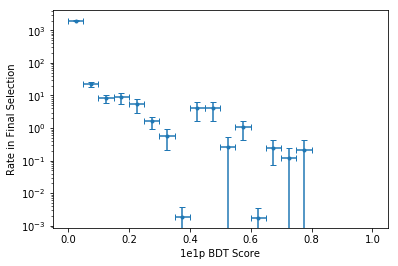

In [4]:
dftotMPID = dftot.query('MPIDY_muon>0.2')
n,xbins,_ = plt.hist(dftotMPID['sigprob'],weights=dftotMPID['weights'],range=(0,1),bins=20)   
var,_,_ = plt.hist(dftotMPID['sigprob'],weights=dftotMPID['weights']**2,range=(0,1),bins=20)
err = np.sqrt(var)
plt.clf()
xbc = 0.5*(xbins[:-1]+xbins[1:])
xbw = 0.5*(xbins[1:]-xbins[:-1])
plt.errorbar(xbc,n,xerr=xbw,yerr=err,fmt='.',capsize=3)
plt.semilogy()
plt.xlabel('1e1p BDT Score')
plt.ylabel('Rate in Final Selection')
plt.show()

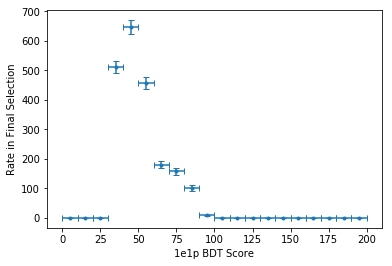

In [5]:
n,xbins,_ = plt.hist(dftotMPID['Electron_Edep'],weights=dftotMPID['weights'],range=(0,200),bins=20)   
var,_,_ = plt.hist(dftotMPID['Electron_Edep'],weights=dftotMPID['weights']**2,range=(0,200),bins=20)
err = np.sqrt(var)
plt.clf()
xbc = 0.5*(xbins[:-1]+xbins[1:])
xbw = 0.5*(xbins[1:]-xbins[:-1])
plt.errorbar(xbc,n,xerr=xbw,yerr=err,fmt='.',capsize=3)
#plt.semilogy()
plt.xlabel('1e1p BDT Score')
plt.ylabel('Rate in Final Selection')
plt.show()

[95.69574547  3.54428687  3.54428687  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          3.54428687  0.          0.          0.
  0.          0.        ]


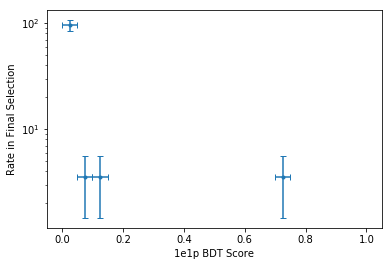

Series([], Name: Enu_1e1p, dtype: float64)
[27.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.]


SelectionHelper.py:550: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  idf['sigprobavg'] = sigprobavg
SelectionHelper.py:551: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  idf['sigprobmedian'] = -1
SelectionHelper.py:552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  idf['sigprobmax'] = -1
SelectionHelper.py:553: Setti

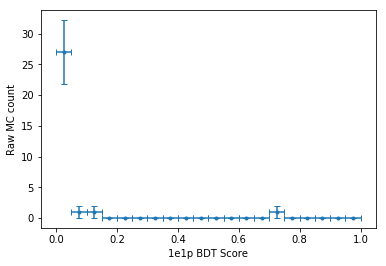

In [6]:
dfdirt = dftot.query('label==\'DIRT\'')
n,xbins,_ = plt.hist(dfdirt['sigprob'],weights=dfdirt['weights'],range=(0,1),bins=20)   
print(n)
var,_,_ = plt.hist(dfdirt['sigprob'],weights=dfdirt['weights']**2,range=(0,1),bins=20)
err = np.sqrt(var)
plt.clf()
xbc = 0.5*(xbins[:-1]+xbins[1:])
xbw = 0.5*(xbins[1:]-xbins[:-1])
plt.errorbar(xbc,n,xerr=xbw,yerr=err,fmt='.',capsize=3)
plt.semilogy()
plt.xlabel('1e1p BDT Score')
plt.ylabel('Rate in Final Selection')
plt.show()

dfdirt = dftot.query('label==\'DIRT\' and datarun==3 and weights>0')
print(dfdirt.query('sigprob>0.9')['Enu_1e1p'])

MakeAvgBDTcut(dfdirt,cut,nBDTs,False,ttc=0.1)
n,xbins,_ = plt.hist(dfdirt['sigprob'],range=(0,1),bins=20)
print(n)
err = np.sqrt(n)
plt.clf()
xbc = 0.5*(xbins[:-1]+xbins[1:])
xbw = 0.5*(xbins[1:]-xbins[:-1])
plt.errorbar(xbc,n,xerr=xbw,yerr=err,fmt='.',capsize=3)
#plt.semilogy()
plt.xlabel('1e1p BDT Score')
plt.ylabel('Raw MC count')
plt.show()